## Process SMA data from Vicari et al., 2023

In [1]:
import os

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import geopandas as gpd

import muon as mu
import scanpy as sc
import squidpy as sq

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def plot_qc(adata):
    mito = 'pct_counts_mt' in adata.obs.columns
    if mito:
        ncol = 3
    else:
        ncol = 2
    fig, axs = plt.subplots(1, ncol, figsize=(20, 4))
    sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
    sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[1])
    if mito:
        sns.distplot(adata.obs["pct_counts_mt"], kde=False, bins=60, ax=axs[2])

In [3]:
path = os.path.join('..', '..', 'data', 'sma')
exp = "V11L12-109" # V11T17-102 V11L12-109 V11T16-085
meta = pd.read_csv(os.path.join(path, 'sma_meta.csv'), index_col=0)

In [4]:
mito = pd.read_csv(os.path.join(path, f"mitocarta_mouse.csv"))
# check if mito['MitoCarta3.0_Evidence'] contains literature, else false
mito['curated'] = [True if 'literature' in x else False for x in mito['MitoCarta3.0_Evidence']]
mito = mito[mito['curated']]
mito_genes = mito['Symbol'].tolist()


## Iteratively process each slide

V11L12-109_A1


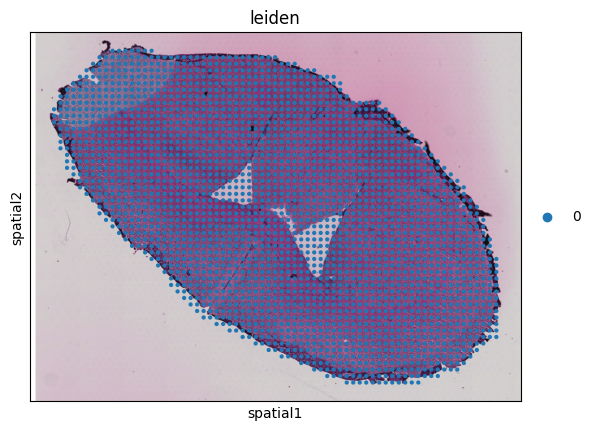

V11L12-109_B1


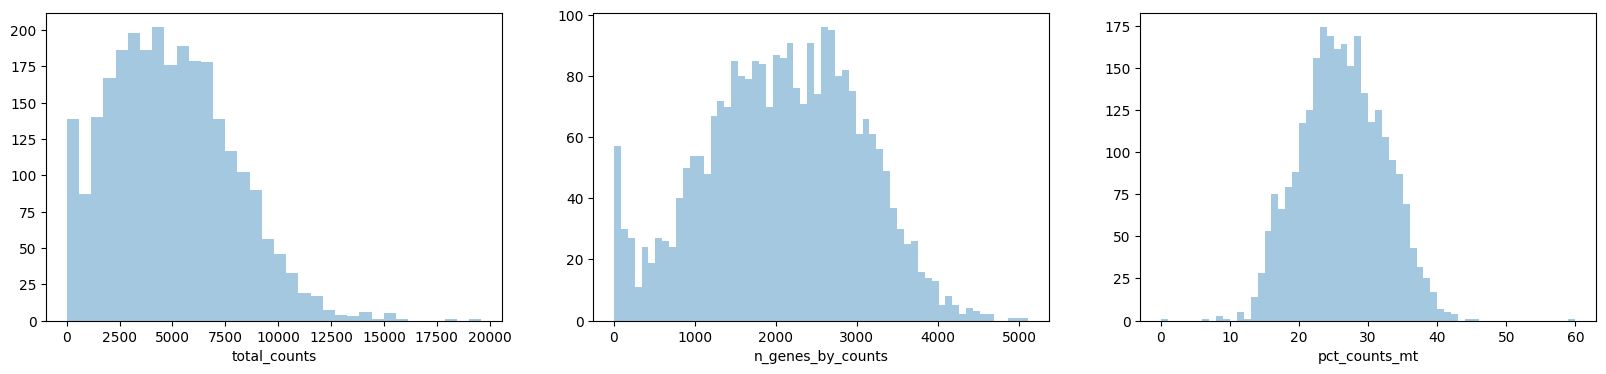

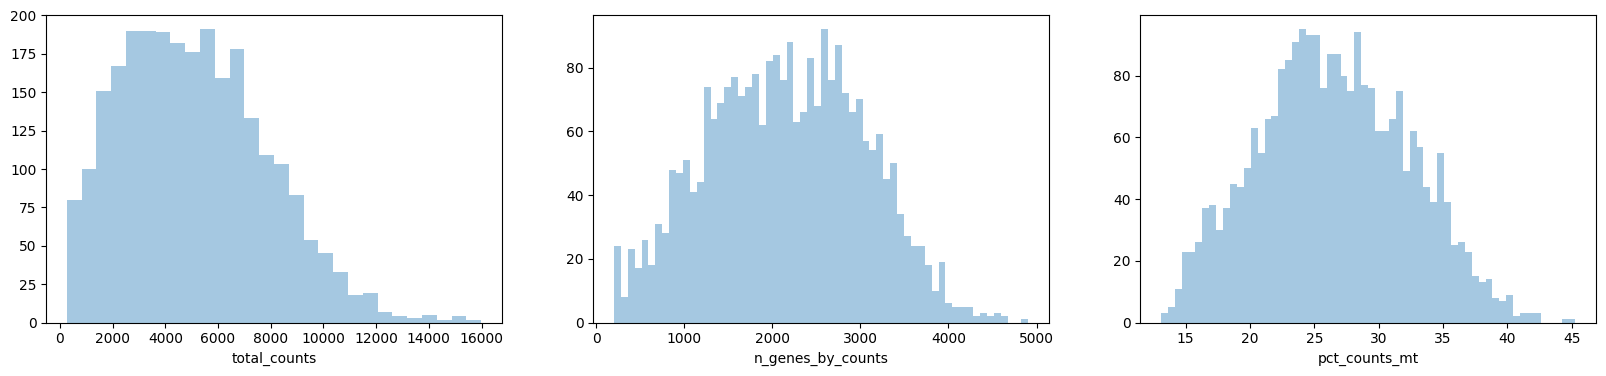

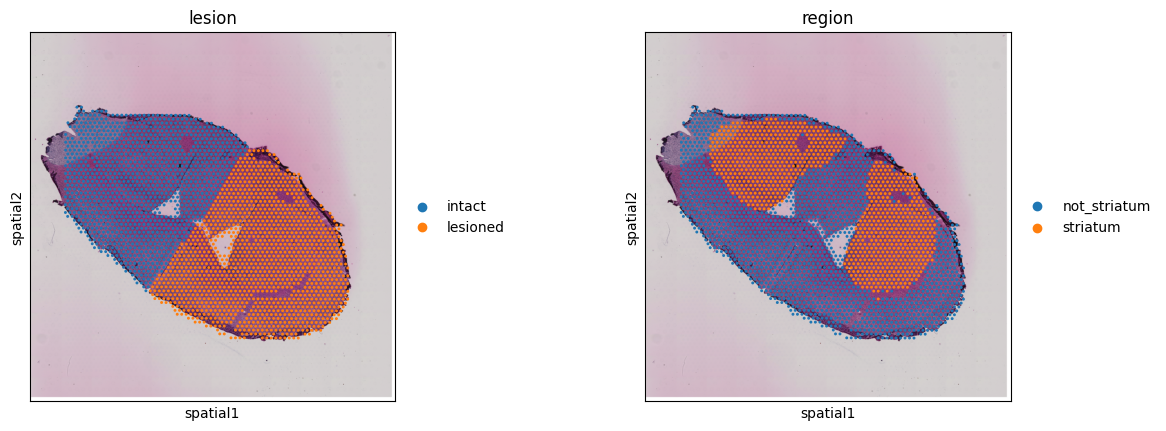

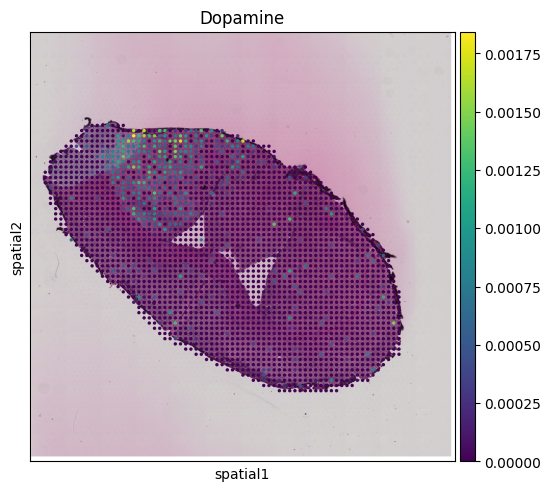

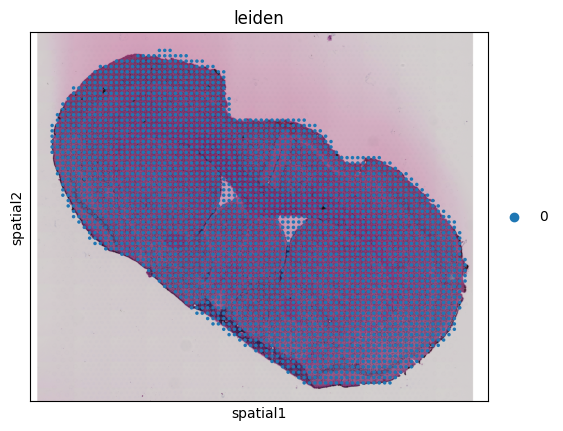

V11L12-109_C1


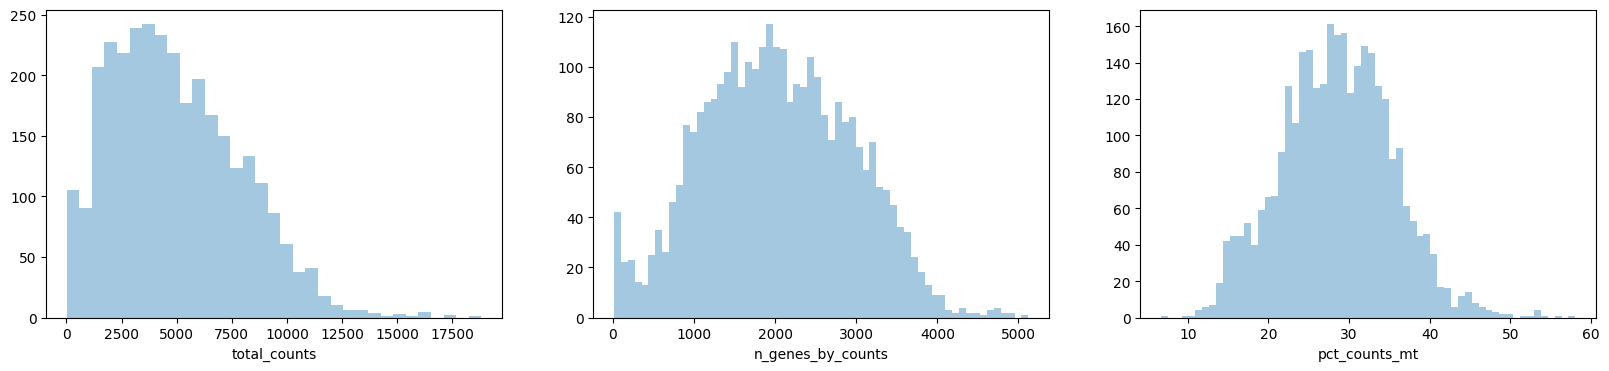

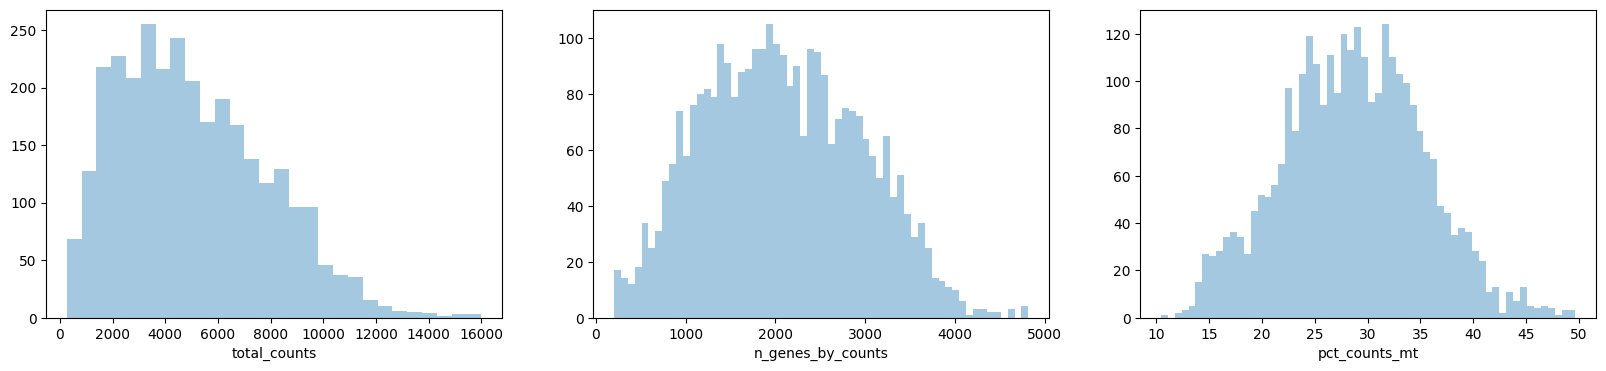

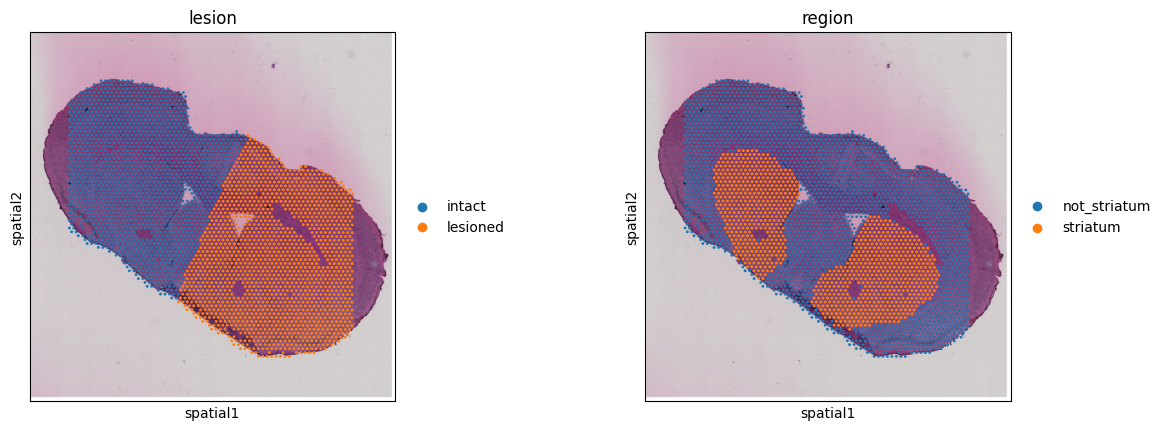

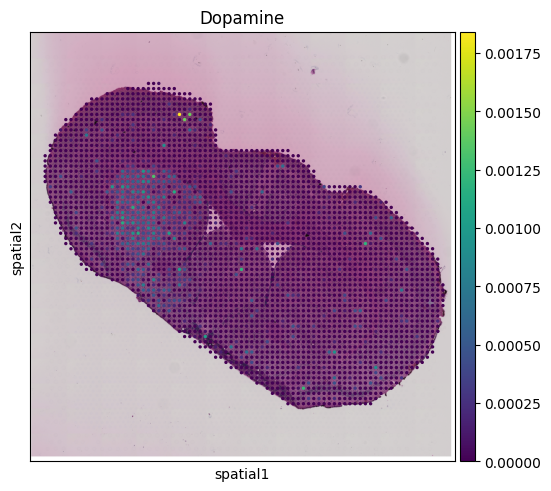

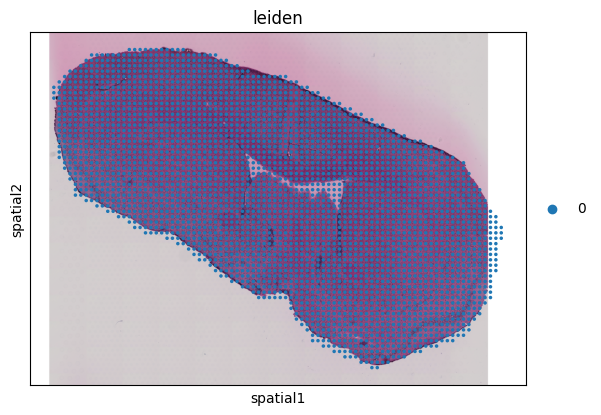

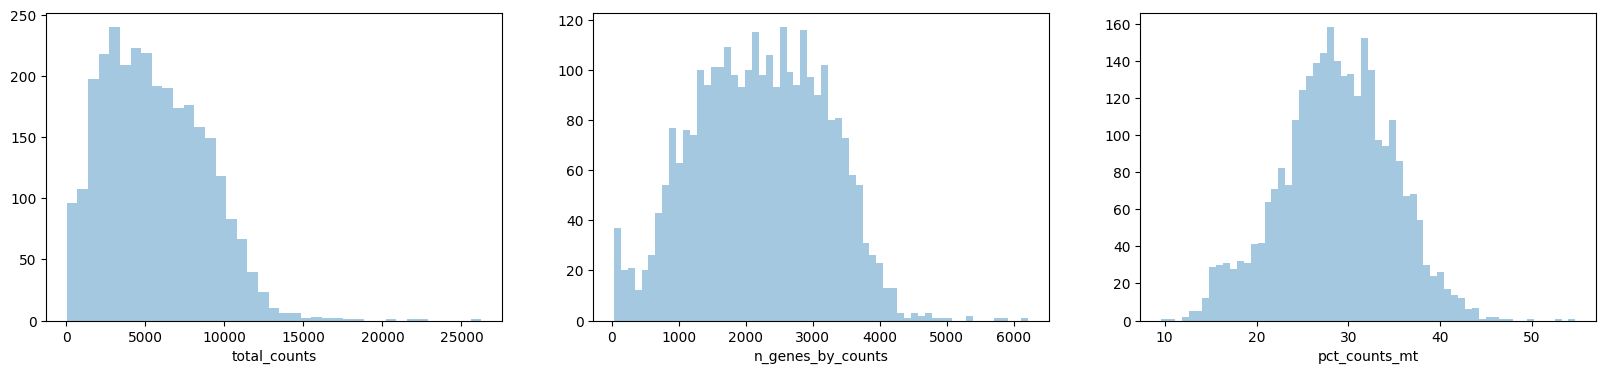

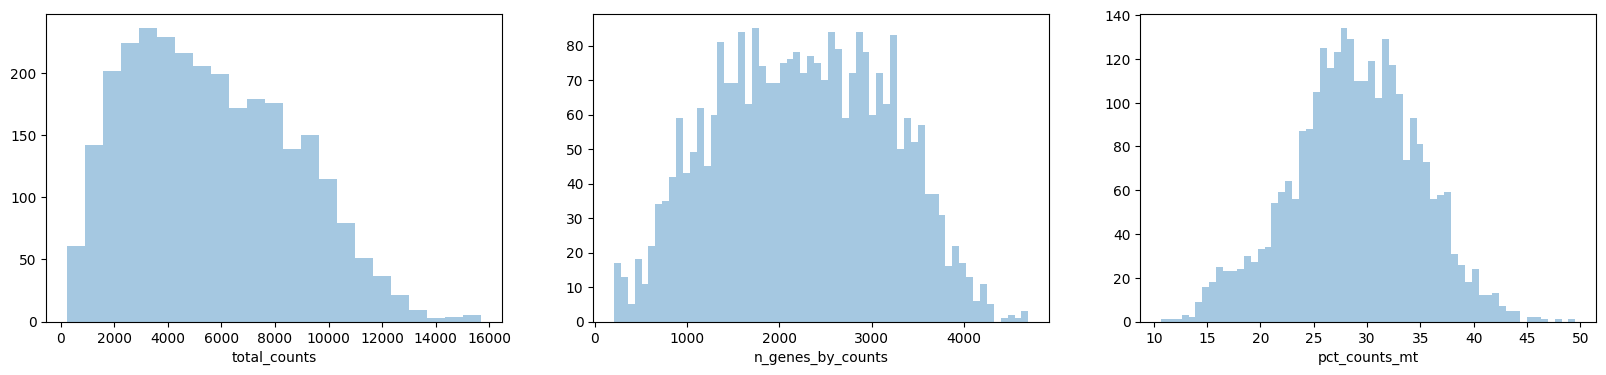

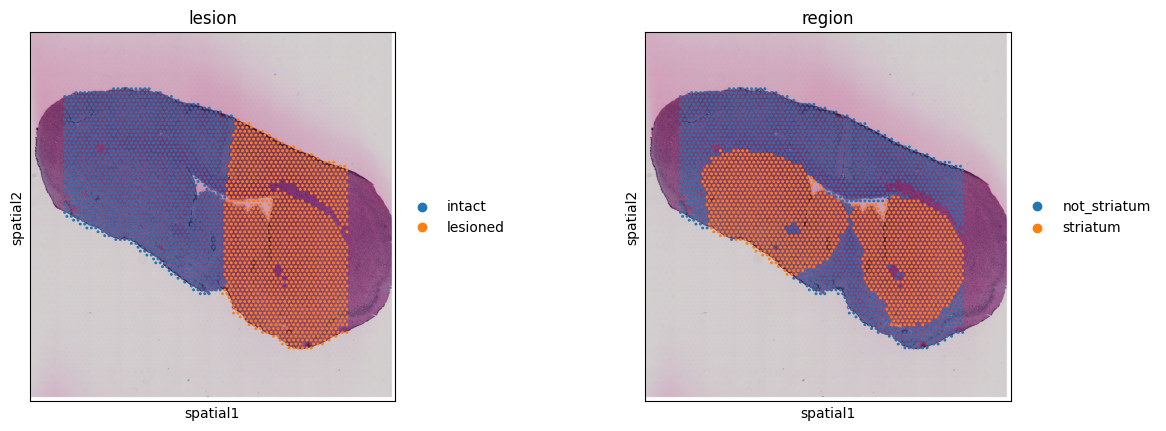

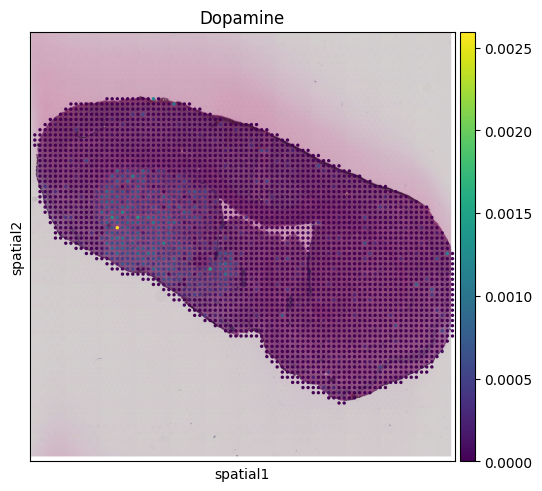

In [5]:
for slide in meta.index:
    
    print(f"{exp}_{slide}")
    
    slide_path = os.path.join(path, exp, f"{exp}_{slide}", "output_data")
    rna_path = os.path.join(slide_path, f"{exp}_{slide}_RNA", "outs")
    msi_path = os.path.join(slide_path, f"{exp}_{slide}_MSI" ,f"{exp}_{slide}.Visium.FMP.220826_smamsi.csv")
    
    rna = sq.read.visium(rna_path, counts_file="filtered_feature_bc_matrix.h5")
    rna.obs[['x', 'y']] = rna.obsm['spatial']

    msi_raw = pd.read_csv(msi_path)
    msi_raw.index = msi_raw[['x', 'y']].astype(str).agg('_'.join, axis=1)
    
    lesion = pd.read_csv(os.path.join(rna_path, "lesion.csv")).set_index("Barcode")
    region = pd.read_csv(os.path.join(rna_path, "region.csv")).set_index("Barcode")
    rna.obs = rna.obs.join(lesion)
    rna.obs = rna.obs.join(region)

    # NOTE: x and y are mirrored in the msi data
    positions = msi_raw[['y', 'x']].values.copy()

    # estimate scaling factor
    sfactor = rna.uns['spatial'][f"{exp}_{slide}"]['scalefactors']['fiducial_diameter_fullres']
    sfactor
    # inverse y
    positions[:, 0] = (positions[:, 0].max() - positions[:, 0])
    # offset
    x_offset = meta.loc[slide][0]
    y_offset = meta.loc[slide][1]

    positions[:, 0] = positions[:, 0] + x_offset
    positions[:, 1] = positions[:, 1] + y_offset

    array_row, array_col = positions[:,0], positions[:, 1]

    # scale
    positions = positions * sfactor * 0.95
    msi = msi_raw.copy().drop(['x', 'y'], axis=1)
    msi = sc.AnnData(X=msi.values,
                    obs=pd.DataFrame(index=msi.index),
                    var=pd.DataFrame(index=msi.columns)
                    )
    msi.obsm['spatial'] = positions
    msi.obs[['x', 'y']] = positions
    msi.obs['array_row'] = array_row
    msi.obs['array_col'] = array_col
    # copy raw intensities
    msi.layers['raw'] = msi.X.copy()
    msi.uns = rna.uns.copy()

    # normalize and cluster (as they do)
    sc.pp.normalize_total(msi, target_sum=1e4)
    sc.pp.log1p(msi)
    sc.pp.scale(msi)
    sc.pp.pca(msi)
    sc.pp.neighbors(msi, n_neighbors=10, n_pcs=20)
    sc.tl.leiden(msi, resolution=0.0002)
    # remove cells that are not in the tissue
    msi = msi[msi.obs['leiden'] != '1', :]
    sc.pl.spatial(msi, color="leiden")
    msi.var_names_make_unique()
    
    ### Process RNA
    rna.var_names_make_unique()
    rna.var["mt"] = rna.var_names.isin(mito_genes)
    sc.pp.calculate_qc_metrics(rna, qc_vars=["mt"], inplace=True)
    plot_qc(rna)
    
    sc.pp.filter_cells(rna, min_genes=200)
    sc.pp.filter_cells(rna, min_counts=100)
    sc.pp.filter_genes(rna, min_cells=3)
    rna = rna[((rna.obs['n_genes_by_counts'] <= 6000) & 
               (rna.obs['total_counts'] <= 16000) & 
               (rna.obs['pct_counts_mt'] <= 50))
              ]
    plot_qc(rna)
    
    # Normalize 
    rna.layers['counts'] = rna.X.copy()
    sc.pp.normalize_total(rna, target_sum=1e4)
    sc.pp.log1p(rna)

    ### Process metabolites
    msi.X = msi.layers['raw'].copy()
    # change type to float
    msi.var['mz'] = msi.var.index.astype(float)
    # round to 2 decimals
    msi.var['mz'] = [round(x, 2) for x in msi.var['mz']]
    msi.var['max_intensity'] = msi.X.sum(axis=0)
    msi.var['mz_raw'] = msi.var.index.astype(str)
    molecule_weights = {
        'GABA': 371.17556, # 371.18,
        'GABA-H2O': 353.16488, # 353.16 (rounding as in paper)
        'Taurine': 393.12718, # 393.13,
        'Serotonin': 444.20746, # 444.21,
        'Histidine': 423.18201, # NOTE: 423.18 Not in supp table
        '3-MT': 435.20706, # 435.21,
        'Dopamine (single)': 421.19146,
        'Dopamine': 674.28041, #  674.28,
        'DOPAC': 689.24381, # 698.24
        'Norepinephrine':690.27435, #  690.28,
        'Tocopherol': 698.49272 # 698.49
    }
    # round to 2 decimals
    molecule_weights = {k: round(v, 2) for k, v in molecule_weights.items()}
    
    msi.var['mz'] = [round(x, 2) for x in msi.var['mz']]
    msi.var['annotated'] = msi.var['mz'].map({v: k for k, v in molecule_weights.items()})
    msi.var['annotated'] = msi.var['annotated'].astype('category')
    # if Name is NaN, then use mz_raw
    msi.var['name'] = msi.var.apply(lambda x: x['mz'] if pd.isnull(x['annotated']) else x['annotated'], axis=1)
    msi.var['name'] = msi.var['name'].astype('str')
    msi.var.set_index('name', inplace=True)
    msi.var.index = msi.var.index.astype(str)

    # drop duplicates
    msi.X = msi.layers['raw'].copy()
    msi = msi[:, ~msi.var.index.duplicated()]
    sc.pp.filter_cells(msi, min_counts=200)
    sc.pp.normalize_total(msi, target_sum=1)

    # Transfer annotations
    rna_points = gpd.points_from_xy(rna.obs['x'], rna.obs['y'].values)
    msi_points = gpd.points_from_xy(msi.obs['x'], msi.obs['y'].values)
    
    # join
    original_gdf = gpd.GeoDataFrame(rna.obs[['region', 'lesion']], geometry=rna_points)
    target_gdf = gpd.GeoDataFrame(msi.obs, geometry=msi_points)
    # target_gdf to orginary df, without geometry
    target_df = pd.DataFrame(target_gdf.sjoin_nearest(original_gdf, how='left').drop(columns='geometry'))

    # fix region join (only for C1)
    if slide=="C1":
        target_df.loc[(target_df['array_row'] >= rna.obs['array_row'].max()) * (target_df['region'] =='striatum'), 'region'] = 'not_striatum'

    # annotations to msi
    msi.obs = target_df
    sq.pl.spatial_scatter(rna, color=['lesion', 'region'])

    # Write
    mdata = mu.MuData({'rna':rna, 'msi':msi})
    mdata = mu.MuData(mdata.mod)
    
    # swap back to raw intensities
    sq.pl.spatial_scatter(mdata.mod['msi'], color=['Dopamine']) # plot dopamine
    
    mdata.write_h5mu(os.path.join(slide_path, "sma.h5mu"))